### Imports, datasets and helper functions

In [1]:
from datetime import date, timedelta, datetime
from math import radians, cos, sin, asin, sqrt, floor

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid

In [2]:
df = pd.read_csv("./../data_temp/training_transformed.csv")
df = df.set_index("geohash6")
df = df.replace(-1, np.nan)
df.columns = pd.DatetimeIndex(df.columns)

# Check number of NaN at first
df.isna().sum().sum()

3576303

In [3]:
NUM_DAYS = (max(df.columns) - min(df.columns)).days + 1

### Filling in by seasonal average

In [4]:
# Estimate missing values, using weekly averages against the first week average

def create_seasonal_df(df, dt):
    global NUM_DAYS
    NUM_WEEKS = floor(NUM_DAYS/7)
    
    # split df by week
    df_list = []
    cols =  [x for x in range(96*7)] # 1 week of cols
    for i in range(NUM_WEEKS):
        temp = df[df.columns[i*96*7: (i+1)*96*7]]
        temp.columns = cols
        df_list.append(temp)
    temp = df[df.columns[NUM_WEEKS*96*7:]] # remaining days
    temp = temp.reindex(columns = cols) # pad
    df_list.append(temp) 
    
    # group by index and average, to get weekly average
    df_week_ave = pd.concat(df_list, axis=0)
    df_week_ave = df_week_ave.groupby(df_week_ave.index).mean()
    
    # get ratio: weekly average divide by first week
    week_ratio = df.transpose().resample('7D').sum().transpose().mean(axis=0)
    week_ratio = (week_ratio / week_ratio[0]).values
    
    # create a seasonal dataframe BY multiplING by weekly average by weekly ratios
    df_seasonal = []
    for i in range(NUM_WEEKS+1):
        df_seasonal.append(df_week_ave*week_ratio[i])
    df_seasonal = pd.concat(df_seasonal, axis=1)
    df_seasonal = df_seasonal.iloc[:, 0:NUM_DAYS*96] # drop padded values
                              
    ''' DEPRECATED - USED TO USE DAILY RATIO TO FILL REMAINING DAYS
    # generate weekly datetime ranges, starting from day=1
    date_range_list = []
    for i in range(NUM_WEEKS+1): # number of weeks +1 to account for remaining dates
        startDate =  dt + timedelta(days=7*i)
        endDate = startDate + timedelta(days=7)
        date_range_list.append(pd.date_range(startDate, endDate, freq="15min").values[:-1]) # skip last entry 

    # split df based on date ranges, then group and average, to get weekly average.
    df_list = []
    for i in (date_range_list):
        temp = df[i]
        temp.columns = [x for x in range(0, len(temp.columns))]
        df_list.append(temp)
    df_week_ave = pd.concat(df_list, axis=0)
    df_week_ave = df_week_ave.groupby(df_week_ave.index).mean()
    
    # get ratio: weekly average divide by first week
    df_temp = df[pd.date_range(dt, dt+timedelta(days=NUM_WEEKS * 7), freq="15min")[:-1]]
    weekly_resampled = df_temp.transpose().resample('7D').sum().transpose().sum(axis=0)
    weekly_resampled = (weekly_resampled / weekly_resampled[0]).values

    # create a seasonal dataframe multipled by weekly average (NUM_DAYS/7 weeks worth)
    df_seasonal = []
    for i in range(NUM_WEEKS+1):
        df_seasonal.append(df_week_ave*weekly_resampled[i])
    df_seasonal = pd.concat(df_seasonal, axis=1)
    
    # handle remaining dates that arent filled using same method but on a daily basis
    # get the remaining days and resample daily
    first_timeslot = NUM_WEEKS*7*96
    temp1 = df[df.columns[first_timeslot:]].transpose().resample('D').sum().transpose().sum(axis=0)
    # get 1 week earlier
    temp2 = df[df.columns[first_timeslot-(7*96):first_timeslot+(7-DAYS_LEFT)*96]].transpose().resample('D').sum().transpose().sum(axis=0)[:DAYS_LEFT]
    ratio = temp1.values/temp2.values

    # Take previous week's 5 days and multiply by ratio, before filling up
    for i in range(DAYS_LEFT):
        start = first_timeslot - (7*96) + 96*i
        end = start + 96
        df_day = df[df.columns[start:end]]
        df_day = df_day * ratio[i]
        df_seasonal = pd.concat([df_seasonal, df_day], axis=1)
    '''
    
    return df_seasonal

In [5]:
# add generated values to df without altering original values

def add_without_alter(df, df_gen):
    df_temp = df.replace(np.nan, -1)
    df_temp[df_temp > 0] = 0
    df_temp = df_temp.replace(-1, 1) # from original df, set np.nan as 1, float value as 0
    df_gen.index, df_gen.columns = df.index, df.columns
    df_gen = df_gen * df_temp # multiply to get rid of original values in df_gen
    
    # now we can just add it to df
    df_gen.index, df_gen.columns = df.index, df.columns
    return (df.replace(np.nan, 0) + df_gen.replace(np.nan, 0)).replace(0, np.nan)

In [6]:
# Fill seasonally

df_seasonal = create_seasonal_df(df, datetime(2019,4,1, 0, 0))
df_seasonal = add_without_alter(df, df_seasonal)

In [7]:
df_seasonal.isna().sum().sum() # filled 1 million values using seasonality

2173762

### Fill the rest by an average of ffill, bfill and interpolate

In [8]:
def fill_rest(df):
    df_ffill = df.ffill(axis=1)
    df_bfill = df.bfill(axis=1)
    df_interpolate = df.interpolate(axis=1)
    return df_ffill, df_bfill, df_interpolate

In [9]:
df_temp = pd.concat(list(fill_rest(df)))
df_temp = df_temp.groupby('geohash6').mean()
df_final = add_without_alter(df_seasonal, df_temp)
del df_temp, df_seasonal

In [10]:
df_final.isna().sum().sum() # filled in all remaining values

0

### Add noise to generated values

In [11]:
# obtain sd per geohash, generate a dataframe of noise=SD/10 and add to only generated values
# adds noise to gen values only, based on original df

def add_noise(df, df_final, multiplier=10):
    mu, sigma = 0, df_final.std(axis=1)
    num_col = len(df_final.columns)

    noise_dict = {}
    for i in range(len(sigma)):
        noise_dict[i] = np.random.normal(mu, sigma[i], [1, num_col]).flatten()

    noise_dict = pd.DataFrame.from_dict(noise_dict,'index')
    noise_dict.index = df_final.index
    noise_dict.columns = df_final.columns

    df = df.replace(np.nan, -1)
    df[df > 0] = 0
    df_temp = df.replace(-1, 1) # from original df, set np.nan as 1, float value as 0
    df_final_noise = (noise_dict/multiplier * df_temp) + df_final # multiply by noise df to obtain noise only for generated values
    df_final_noise[df_final_noise < 0] = 0
    return df_final_noise

In [12]:
df_final_noise = add_noise(df, df_final)
df_final_noise.to_csv("./../data_temp/df_transformed_filled.csv")

### Plot with noise for comparison

C:\Users\JiaWei\Anaconda3\envs\GrabTraffic\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


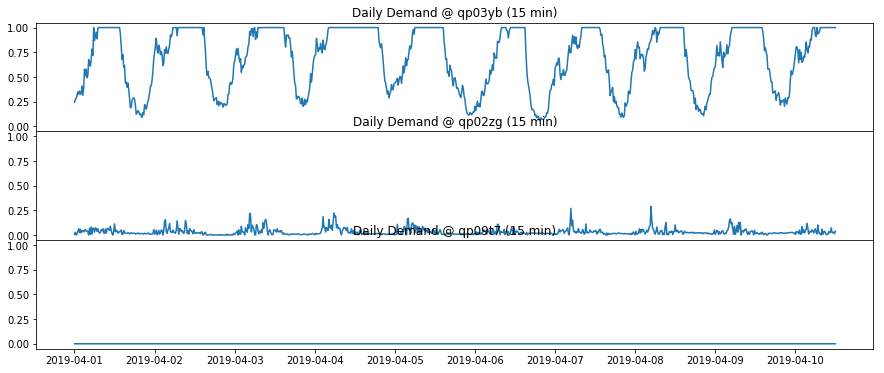

In [13]:
df_transformed = df_final_noise.replace(np.nan, 0)

def get_timespan_15(df, startTime, endTime, freq='15min'):
    return df[pd.date_range(startTime, endTime, freq=freq)] # inclusive

# Demand per location over time (15min)
geohash_str_1 = 'qp03yb'
geohash_str_2 = 'qp02zg'
geohash_str_3 = 'qp09t7'

start_date = datetime(2019, 4, 1, 0)
end_date = datetime(2019, 4, 10, 12)
x = pd.date_range(start_date, end_date, freq="15min").values

y1 = get_timespan_15(df_transformed[df_transformed.index==geohash_str_1], start_date, end_date).values.flatten() # inclusive
y2 = get_timespan_15(df_transformed[df_transformed.index==geohash_str_2], start_date, end_date).values.flatten()
y3 = get_timespan_15(df_transformed[df_transformed.index==geohash_str_3], start_date, end_date).values.flatten()

# Three subplots sharing both x/y axes
f, (ax1, ax2, ax3) = plt.subplots(3, sharey=True)
ax1.set_title('Daily Demand @ {} (15 min)'.format(geohash_str_1))
ax2.set_title('Daily Demand @ {} (15 min)'.format(geohash_str_2))
ax3.set_title('Daily Demand @ {} (15 min)'.format(geohash_str_3))
ax1.plot(x, y1)
ax2.plot(x, y2)
ax3.plot(x, y3)

# Fine-tune figure; make subplots close to each other and hide x ticks for
# all but bottom plot.
f.subplots_adjust(hspace=0)
f.set_figheight(6)
f.set_figwidth(15)